
# **F1 피트스톱 최적화 전략**

- F1 레이스에서 피트스톱은 승패를 좌우하는 중요한 전략적 요소이다.
- 피트스톱은 빠르게 진행하는 것은 기본이거니와, 레이스 중 **언제** 들어가는지가 핵심
- 피트스톱 타이밍이 잘못되면 트랙 포지션을 잃거나, 타이어 성능 저하로 인해 순위가 급락할 수 있다.
- 이런 피트스톱의 "타이밍"이 팀별로 중요한 전략인 것!


> 이번 TASK를 통해 특정 드라이버가 **어느 랩에 피트스톱을 하면 가장 유리한지**를 예측하는 모델링 과정을 연습해보려 한다.


### **모델의 주요 목표**
1. **최적의 피트스톱 타이밍 예측**: 특정 경기장에서 특정 드라이버가 언제 피트스톱을 하면 가장 좋은 결과를 얻을지 피트스톱 타이밍을 예측
2. **피트스톱 전략과 레이스 성적 간 관계 분석**: 피트스톱이 **승률, 포디움 여부, 포지션 상승** 등에 미치는 영향 평가

F1 팀이 보다 **효율적인 피트스톱 전략**을 수립할 수 있으며, 실시간 데이터 적용을 통해 경기 중 전략을 최적화하는 데도 도움을 줄 수 있을 것으로 기대

### 데이터셋 불러오기

In [1]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# 데이터셋 불러오기
races = pd.read_csv('/content/drive/MyDrive/EPOCH/study/TASK/races.csv')
drivers = pd.read_csv('/content/drive/MyDrive/EPOCH/study/TASK/drivers.csv')
lap_times = pd.read_csv('/content/drive/MyDrive/EPOCH/study/TASK/lap_times.csv')
pit_stops = pd.read_csv('/content/drive/MyDrive/EPOCH/study/TASK/pit_stops.csv')
results = pd.read_csv('/content/drive/MyDrive/EPOCH/study/TASK/results.csv')
circuits = pd.read_csv('/content/drive/MyDrive/EPOCH/study/TASK/circuits.csv')

### 데이터셋 살펴보기 & 병합

In [3]:
races.head()

,raceId,year,round,circuitId,name,date,time,url,fp1_date,fp1_time,fp2_date,fp2_time,fp3_date,fp3_time,quali_date,quali_time,sprint_date,sprint_time
0,1,2009,1,1,Australian Grand Prix,2009-03-29,06:00:00,http://en.wikipedia.org/wiki/2009_Australian_G...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
1,2,2009,2,2,Malaysian Grand Prix,2009-04-05,09:00:00,http://en.wikipedia.org/wiki/2009_Malaysian_Gr...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
2,3,2009,3,17,Chinese Grand Prix,2009-04-19,07:00:00,http://en.wikipedia.org/wiki/2009_Chinese_Gran...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
3,4,2009,4,3,Bahrain Grand Prix,2009-04-26,12:00:00,http://en.wikipedia.org/wiki/2009_Bahrain_Gran...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
4,5,2009,5,4,Spanish Grand Prix,2009-05-10,12:00:00,http://en.wikipedia.org/wiki/2009_Spanish_Gran...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N


In [4]:
lap_times.head()

,raceId,driverId,lap,position,time,milliseconds
0,841,20,1,1,1:38.109,98109
1,841,20,2,1,1:33.006,93006
2,841,20,3,1,1:32.713,92713
3,841,20,4,1,1:32.803,92803
4,841,20,5,1,1:32.342,92342


In [5]:
pit_stops.head()

,raceId,driverId,stop,lap,time,duration,milliseconds
0,841,153,1,1,17:05:23,26.898,26898
1,841,30,1,1,17:05:52,25.021,25021
2,841,17,1,11,17:20:48,23.426,23426
3,841,4,1,12,17:22:34,23.251,23251
4,841,13,1,13,17:24:10,23.842,23842


In [6]:
results.head()

,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,laps,time,milliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId
0,1,18,1,1,22,1,1,1,1,10.0,58,1:34:50.616,5690616,39,2,1:27.452,218.300,1
1,2,18,2,2,3,5,2,2,2,8.0,58,+5.478,5696094,41,3,1:27.739,217.586,1
2,3,18,3,3,7,7,3,3,3,6.0,58,+8.163,5698779,41,5,1:28.090,216.719,1
3,4,18,4,4,5,11,4,4,4,5.0,58,+17.181,5707797,58,7,1:28.603,215.464,1
4,5,18,5,1,23,3,5,5,5,4.0,58,+18.014,5708630,43,1,1:27.418,218.385,1


In [7]:
circuits.head()

,circuitId,circuitRef,name,location,country,lat,lng,alt,url
0,1,albert_park,Albert Park Grand Prix Circuit,Melbourne,Australia,-37.84970,144.96800,10,http://en.wikipedia.org/wiki/Melbourne_Grand_P...
1,2,sepang,Sepang International Circuit,Kuala Lumpur,Malaysia,2.76083,101.73800,18,http://en.wikipedia.org/wiki/Sepang_Internatio...
2,3,bahrain,Bahrain International Circuit,Sakhir,Bahrain,26.03250,50.51060,7,http://en.wikipedia.org/wiki/Bahrain_Internati...
3,4,catalunya,Circuit de Barcelona-Catalunya,Montmeló,Spain,41.57000,2.26111,109,http://en.wikipedia.org/wiki/Circuit_de_Barcel...
4,5,istanbul,Istanbul Park,Istanbul,Turkey,40.95170,29.40500,130,http://en.wikipedia.org/wiki/Istanbul_Park


In [8]:
datasets = {"races": races, "drivers": drivers, "lap_times": lap_times, "pit_stops": pit_stops, "results": results, "circuits": circuits}

for name, df in datasets.items():
    print(f"Dataset: {name}")
    print(df.head(), "\n")
    print(df.info(), "\n")

Dataset: races
   raceId  year  round  circuitId                   name        date  \
0       1  2009      1          1  Australian Grand Prix  2009-03-29   
1       2  2009      2          2   Malaysian Grand Prix  2009-04-05   
2       3  2009      3         17     Chinese Grand Prix  2009-04-19   
3       4  2009      4          3     Bahrain Grand Prix  2009-04-26   
4       5  2009      5          4     Spanish Grand Prix  2009-05-10   

       time                                                url fp1_date  \
0  06:00:00  http://en.wikipedia.org/wiki/2009_Australian_G...       \N   
1  09:00:00  http://en.wikipedia.org/wiki/2009_Malaysian_Gr...       \N   
2  07:00:00  http://en.wikipedia.org/wiki/2009_Chinese_Gran...       \N   
3  12:00:00  http://en.wikipedia.org/wiki/2009_Bahrain_Gran...       \N   
4  12:00:00  http://en.wikipedia.org/wiki/2009_Spanish_Gran...       \N   

  fp1_time fp2_date fp2_time fp3_date fp3_time quali_date quali_time  \
0       \N       \N       \N 

**데이터셋 병합을 위한 간단한 전처리**

```
불필요한 컬럼은 미리 전처리
```



In [9]:
races = races.drop(columns=["url", "fp1_date", "fp1_time", "fp2_date", "fp2_time", "fp3_date", "fp3_time", "quali_date", "quali_time", "sprint_date", "sprint_time"], errors='ignore')
circuits = circuits.drop(columns=["url"], errors='ignore')
results = results.drop(columns=["positionText", "fastestLapTime", "fastestLapSpeed"], errors='ignore')

```
중복되는 변수명 구분될 수 있도록 Rename
```

In [10]:
races = races.rename(columns={"name": "race_name"})
circuits = circuits.rename(columns={"name": "circuit_name", "location": "circuit_location", "country": "circuit_country"})

```
key변수를 기준으로 JOIN 병합
```

In [11]:
df = (
    pit_stops
    .merge(lap_times, on=["raceId", "driverId", "lap"], how="left", suffixes=("_pits", "_laps"))
    .merge(races, on=["raceId"], how="left", suffixes=("", "_races"))
    .merge(results, on=["raceId", "driverId"], how="left", suffixes=("", "_results"))
    .merge(circuits, on=["circuitId"], how="left", suffixes=("", "_circuits"))
)

### 기초 통계 확인

다운받아서 확인

In [12]:
from google.colab import files
df.to_csv('your_file_name.csv', index=False)

files.download('your_file_name.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Null값 존재 X

원본 데이터부터가 어느정도 잘정제되어 있는 데이터긴 했음

In [13]:
df.head()

,raceId,driverId,stop,lap,time_pits,duration,milliseconds_pits,position,time_laps,milliseconds_laps,...,fastestLap,rank,statusId,circuitRef,circuit_name,circuit_location,circuit_country,lat,lng,alt
0,841,153,1,1,17:05:23,26.898,26898,21,2:13.879,133879,...,41,10,11,albert_park,Albert Park Grand Prix Circuit,Melbourne,Australia,-37.8497,144.968,10
1,841,30,1,1,17:05:52,25.021,25021,22,2:41.428,161428,...,13,21,4,albert_park,Albert Park Grand Prix Circuit,Melbourne,Australia,-37.8497,144.968,10
2,841,17,1,11,17:20:48,23.426,23426,7,1:54.995,114995,...,50,3,1,albert_park,Albert Park Grand Prix Circuit,Melbourne,Australia,-37.8497,144.968,10
3,841,4,1,12,17:22:34,23.251,23251,12,1:52.624,112624,...,49,2,1,albert_park,Albert Park Grand Prix Circuit,Melbourne,Australia,-37.8497,144.968,10
4,841,13,1,13,17:24:10,23.842,23842,11,1:54.060,114060,...,55,1,1,albert_park,Albert Park Grand Prix Circuit,Melbourne,Australia,-37.8497,144.968,10


In [14]:
df.tail()

,raceId,driverId,stop,lap,time_pits,duration,milliseconds_pits,position,time_laps,milliseconds_laps,...,fastestLap,rank,statusId,circuitRef,circuit_name,circuit_location,circuit_country,lat,lng,alt
11366,1144,840,2,32,17:52:48,22.053,22053,12,1:32.228,92228,...,42,11,11,yas_marina,Yas Marina Circuit,Abu Dhabi,UAE,24.4672,54.6031,3
11367,1144,1,1,34,17:55:17,21.694,21694,4,1:31.792,91792,...,44,2,1,yas_marina,Yas Marina Circuit,Abu Dhabi,UAE,24.4672,54.6031,3
11368,1144,4,2,37,18:00:10,22.437,22437,9,1:31.999,91999,...,51,7,1,yas_marina,Yas Marina Circuit,Abu Dhabi,UAE,24.4672,54.6031,3
11369,1144,855,2,39,18:03:21,28.765,28765,10,1:31.750,91750,...,56,8,11,yas_marina,Yas Marina Circuit,Abu Dhabi,UAE,24.4672,54.6031,3
11370,1144,825,4,55,18:28:06,22.090,22090,16,1:31.958,91958,...,57,1,11,yas_marina,Yas Marina Circuit,Abu Dhabi,UAE,24.4672,54.6031,3


In [15]:
df.describe()

,raceId,driverId,stop,lap,milliseconds_pits,position,milliseconds_laps,year,round,circuitId,resultId,constructorId,grid,positionOrder,points,laps,statusId,lat,lng,alt
count,11371.000000,11371.000000,11371.000000,11371.000000,1.137100e+04,11371.000000,1.137100e+04,11371.000000,11371.000000,11371.000000,11371.000000,11371.000000,11371.000000,11371.000000,11371.000000,11371.000000,11371.000000,11371.000000,11371.000000,11371.000000
mean,981.194882,549.734500,1.787969,25.387389,8.523050e+04,10.186175,1.288920e+05,2017.171049,10.550787,23.592736,23627.528010,71.237358,10.807317,10.498285,5.036408,57.797555,7.868613,29.739610,27.334227,212.433207
std,92.326831,383.734981,1.521462,14.831497,3.104273e+05,5.891028,1.847831e+05,4.241669,6.004157,24.068750,1783.312755,85.881681,6.235787,5.759583,7.207363,11.387181,16.658946,23.706913,64.455749,381.365376
min,841.000000,1.000000,1.000000,1.000000,1.289700e+04,1.000000,5.909100e+04,2011.000000,1.000000,1.000000,20779.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,-37.849700,-115.173000,-7.000000
25%,895.000000,20.000000,1.000000,13.000000,2.193750e+04,5.000000,9.393000e+04,2013.000000,5.000000,7.000000,22035.000000,5.000000,5.000000,6.000000,0.000000,53.000000,1.000000,24.467200,2.261110,7.000000
50%,971.000000,817.000000,2.000000,25.000000,2.360600e+04,10.000000,1.048830e+05,2017.000000,10.000000,15.000000,23432.000000,10.000000,11.000000,11.000000,0.000000,57.000000,1.000000,39.458900,14.764700,45.000000
75%,1065.000000,835.000000,2.000000,36.000000,2.654400e+04,15.000000,1.189130e+05,2021.000000,15.000000,24.000000,25250.000000,131.000000,16.000000,15.000000,9.000000,67.000000,11.000000,47.219700,54.603100,264.000000
max,1144.000000,862.000000,70.000000,78.000000,3.069017e+06,24.000000,3.803459e+06,2024.000000,24.000000,80.000000,26763.000000,215.000000,24.000000,24.000000,50.000000,87.000000,141.000000,52.388800,144.968000,2227.000000


**범주형/수치형 변수 탐색**

In [16]:
int_col = df.select_dtypes(include=['int64', 'float64'])
obj_col = df.select_dtypes(include=['object'])

In [17]:
int_col.describe()

,raceId,driverId,stop,lap,milliseconds_pits,position,milliseconds_laps,year,round,circuitId,resultId,constructorId,grid,positionOrder,points,laps,statusId,lat,lng,alt
count,11371.000000,11371.000000,11371.000000,11371.000000,1.137100e+04,11371.000000,1.137100e+04,11371.000000,11371.000000,11371.000000,11371.000000,11371.000000,11371.000000,11371.000000,11371.000000,11371.000000,11371.000000,11371.000000,11371.000000,11371.000000
mean,981.194882,549.734500,1.787969,25.387389,8.523050e+04,10.186175,1.288920e+05,2017.171049,10.550787,23.592736,23627.528010,71.237358,10.807317,10.498285,5.036408,57.797555,7.868613,29.739610,27.334227,212.433207
std,92.326831,383.734981,1.521462,14.831497,3.104273e+05,5.891028,1.847831e+05,4.241669,6.004157,24.068750,1783.312755,85.881681,6.235787,5.759583,7.207363,11.387181,16.658946,23.706913,64.455749,381.365376
min,841.000000,1.000000,1.000000,1.000000,1.289700e+04,1.000000,5.909100e+04,2011.000000,1.000000,1.000000,20779.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,-37.849700,-115.173000,-7.000000
25%,895.000000,20.000000,1.000000,13.000000,2.193750e+04,5.000000,9.393000e+04,2013.000000,5.000000,7.000000,22035.000000,5.000000,5.000000,6.000000,0.000000,53.000000,1.000000,24.467200,2.261110,7.000000
50%,971.000000,817.000000,2.000000,25.000000,2.360600e+04,10.000000,1.048830e+05,2017.000000,10.000000,15.000000,23432.000000,10.000000,11.000000,11.000000,0.000000,57.000000,1.000000,39.458900,14.764700,45.000000
75%,1065.000000,835.000000,2.000000,36.000000,2.654400e+04,15.000000,1.189130e+05,2021.000000,15.000000,24.000000,25250.000000,131.000000,16.000000,15.000000,9.000000,67.000000,11.000000,47.219700,54.603100,264.000000
max,1144.000000,862.000000,70.000000,78.000000,3.069017e+06,24.000000,3.803459e+06,2024.000000,24.000000,80.000000,26763.000000,215.000000,24.000000,24.000000,50.000000,87.000000,141.000000,52.388800,144.968000,2227.000000


In [18]:
obj_col.describe()

,time_pits,duration,time_laps,race_name,date,time,number,position_results,time_results,milliseconds,fastestLap,rank,circuitRef,circuit_name,circuit_location,circuit_country
count,11371,11371,11371,11371,11371,11371,11371,11371,11371,11371,11371,11371,11371,11371,11371,11371
unique,8227,7604,10359,40,285,29,54,25,3050,3075,80,25,35,35,35,30
top,15:06:11,22.534,1:33.391,Spanish Grand Prix,2023-08-27,12:00:00,11,\N,\N,\N,50,1,interlagos,Autódromo José Carlos Pace,São Paulo,Spain
freq,6,8,4,669,101,3260,559,953,5010,5010,514,666,701,701,701,783


In [19]:
df.drop_duplicates()
df.shape

(11371, 36)

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11371 entries, 0 to 11370
Data columns (total 36 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   raceId             11371 non-null  int64  
 1   driverId           11371 non-null  int64  
 2   stop               11371 non-null  int64  
 3   lap                11371 non-null  int64  
 4   time_pits          11371 non-null  object 
 5   duration           11371 non-null  object 
 6   milliseconds_pits  11371 non-null  int64  
 7   position           11371 non-null  int64  
 8   time_laps          11371 non-null  object 
 9   milliseconds_laps  11371 non-null  int64  
 10  year               11371 non-null  int64  
 11  round              11371 non-null  int64  
 12  circuitId          11371 non-null  int64  
 13  race_name          11371 non-null  object 
 14  date               11371 non-null  object 
 15  time               11371 non-null  object 
 16  resultId           113

### **변수(컬럼) 분석 노트**

| 변수명              | 변수 설명                                     | 변수 아이디어                                       |
|--------------------|--------------------------------------|--------------------------------------|
| raceId           | 각 레이스(그랑프리) 고유 ID               | 경기별 데이터를 구분하는 기본 식별자 |
| driverId         | 각 드라이버의 고유 ID                  | 드라이버별 피트스톱 패턴을 분석     |
| stop            | 현재 경기에서 해당 드라이버의 피트스톱 횟수   | 드라이버가 여러 번 피트스톱을 하는지 여부 분석 (일반적으로 1회, 당연히 적을수록 좋음) |
| lap             | 해당 피트스톱이 발생한 랩               | 피트스톱이 주로 어느 랩에서 발생하는지 분석 |
| time_pits       | 피트스톱이 이루어진 시간               | 피트스톱이 경기 중 어느 시점에 발생하는지 확인 |
| duration        | 피트스톱 소요 시간 (초 단위)            | 피트스톱 소요 시간이 짧을수록 순위에 미치는 영향 분석 |
| milliseconds_pits | 피트스톱 소요 시간 (밀리초 단위)       | 정밀한 분석을 위해 사용 가능 |
| position        | 피트스톱 직전 드라이버의 순위           | 피트스톱 전후 순위 변화 분석 |
| time_laps       | 해당 랩에서의 기록된 시간             | 타이어 마모 정도나 경기 진행 중 성능 변화 분석 |
| milliseconds_laps | 해당 랩에서의 기록된 시간 (밀리초)   | 정밀한 랩 타임 분석 |
| year            | 경기가 열린 연도                     | 연도별 트렌드 변화 분석 |
| round           | 해당 시즌에서 몇 번째 경기인지         | 시즌 내 경기 진행 상황과 피트스톱 전략 비교 |
| circuitId       | 서킷의 고유 ID                     | 서킷별 피트스톱 전략 비교 |
| race_name       | 해당 레이스(그랑프리)의 이름           | 경기별 데이터를 구별하는 데 사용 |
| date           | 경기가 열린 날짜                     | 날씨 및 계절적 요인과의 관계 분석 |
| time           | 경기가 시작된 시간                   | 트랙 온도 및 날씨와 피트스톱 간의 관계 분석 |
| resultId       | 결과 테이블에서의 고유 ID            | 각 경기의 결과를 특정하는데 사용 |
| constructorId   | 해당 드라이버가 소속된 팀의 ID        | 팀별 피트스톱 전략 비교 |
| number         | 드라이버의 차량 번호                 | 특정 드라이버를 구분 |
| grid           | 드라이버의 출발 위치                 | 출발 위치가 피트스톱 전략에 미치는 영향 분석 |
| position_results | 최종 경기 결과의 텍스트 표현       | 경기 최종 결과 분석 |
| positionOrder  | 드라이버의 최종 순위(position_results)랑 겹침 얘만 남기기                | 피트스톱이 최종 성적에 미치는 영향 분석 |
| points         | 해당 경기에서 드라이버가 획득한 포인트 | 피트스톱과 포인트 획득 간 관계 분석 |
| laps          | 드라이버가 완주한 랩 수               | 경기 중 피트스톱이 경기에 미치는 영향 |
| time_results   | 경기 종료 후 드라이버의 총 기록 시간   | 경기 시간과 피트스톱 간 관계 분석 |
| milliseconds   | 총 경기 시간 (밀리초 단위)            | 정밀한 성능 분석 |
| fastestLap     | 해당 경기에서 드라이버가 기록한 최고 랩 | 타이어 성능과 피트스톱 시점 간 관계 분석 |
| rank           | 최고 랩을 기준으로 드라이버 랭킹       | 빠른 랩을 유지하는 것이 피트스톱과 관계가 있는지 분석 |
| statusId       | 드라이버의 경기 완료 여부            | DNF(리타이어) 여부와 피트스톱 관계 분석 |
| circuitRef     | 서킷의 식별 코드                     | 서킷별 특징 분석 |
| circuit_name   | 서킷 이름                          | 경기장을 기준으로 전략 차이 분석 |
| circuit_location | 서킷이 위치한 도시               | 지리적 요소가 경기 전략에 미치는 영향 분석 |
| circuit_country | 서킷이 위치한 국가               | 국가별 기후 조건과 피트스톱 간 관계 분석 |
| lat           | 서킷의 위도                        | 트랙 환경 및 날씨 영향을 분석 |
| lng           | 서킷의 경도                        | 트랙 환경 및 날씨 영향을 분석 |
| alt           | 서킷의 해발고도                    | 고도가 차량 성능 및 피트스톱 전략에 미치는 영향 분석 |


### **EDA(탐색적 데이터 분석)**

### 타깃 변수 생성 전 EDA

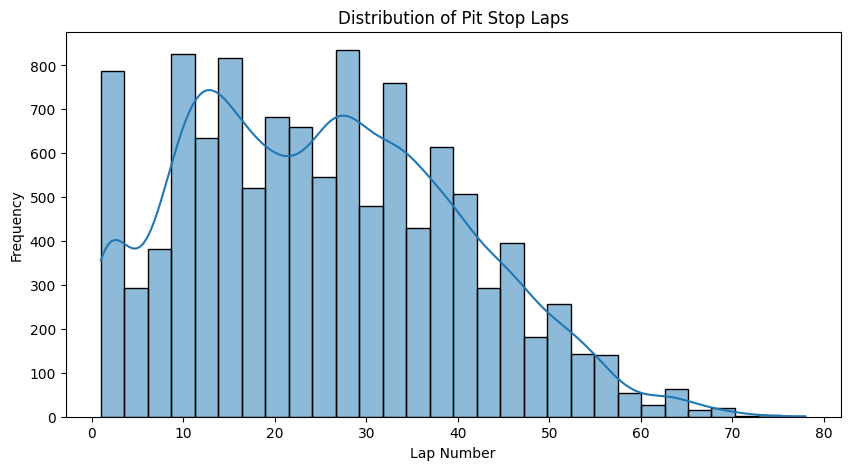

In [22]:
# 피트스톱 랩(lap) 분포
# 피트스톱이 주로 어느(몇번째) 랩에서 발생하는지 분석
# 이렇게 보다는 상대적으로 봐야 유의미할 것 같긴 하다. 경기마다 총 랩수가 다를테니까.

# 주로 경기 중후반대 랩에서 많이 발생

plt.figure(figsize=(10, 5))
sns.histplot(df["lap"], bins=30, kde=True)
plt.title("Distribution of Pit Stop Laps")
plt.xlabel("Lap Number")
plt.ylabel("Frequency")
plt.show()

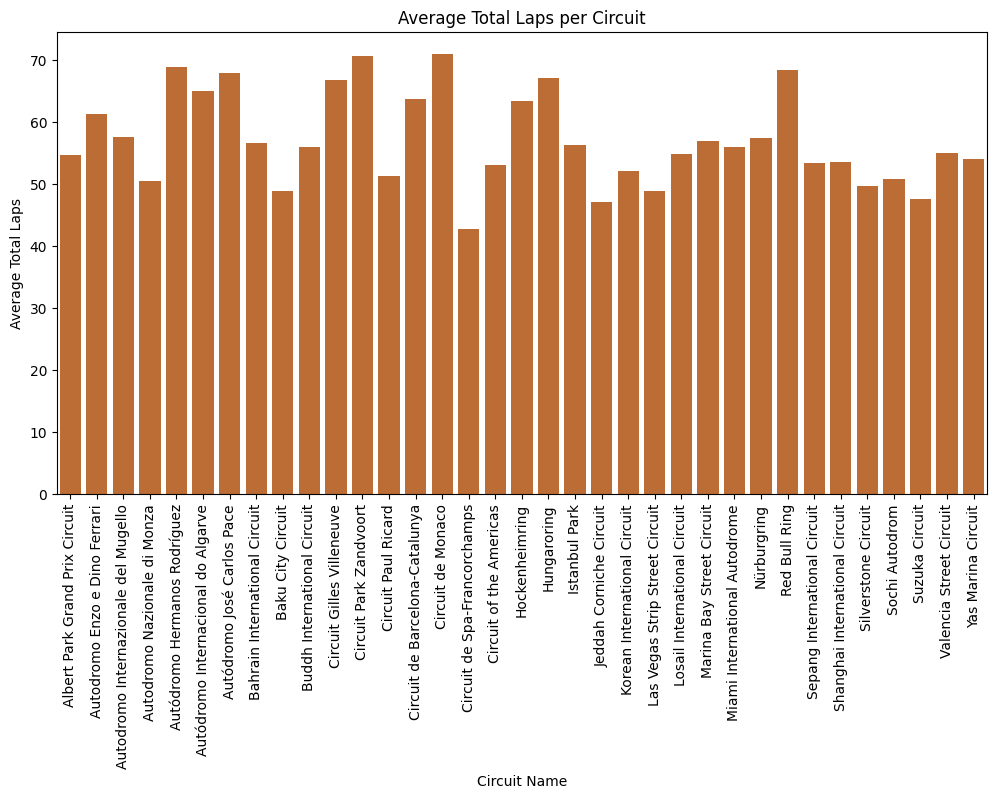

In [23]:
# 서킷별 평균 총 랩수 계산
average_laps_per_circuit = df.groupby('circuit_name')['laps'].mean().reset_index()

# 서킷별 평균 총 랩수 시각화
plt.figure(figsize=(12, 6))
sns.barplot(data=average_laps_per_circuit, x='circuit_name', y='laps', color='chocolate')
plt.title("Average Total Laps per Circuit")
plt.xlabel("Circuit Name")
plt.ylabel("Average Total Laps")
plt.xticks(rotation=90)
plt.show()

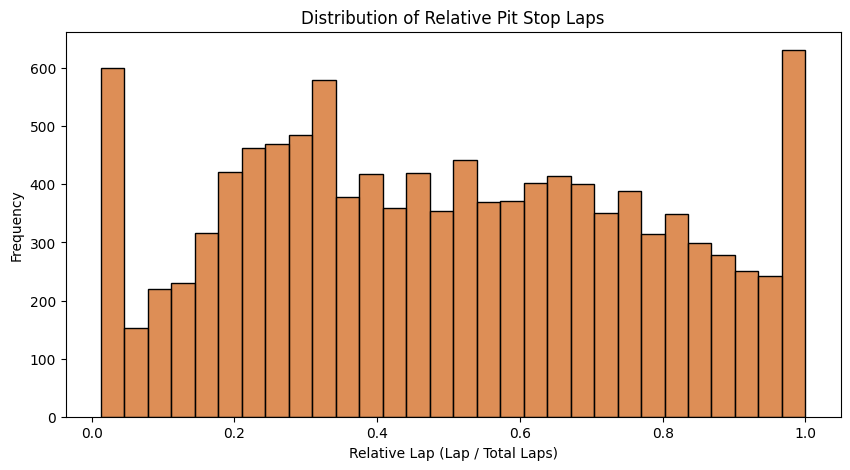

In [60]:
# 피트스톱 랩을 상대적으로 분석하기 위해 각 경기별 총 랩수를 기준으로 상대적 랩수를 계산
# 각 피트스톱이 발생한 랩 번호를 해당 경기의 전체 랩수로 나눈 값
# (피트스톱 랩) / (해당 경기 전체 랩 수)
# 0 ~ 1 값으로 표시

df['relative_lap'] = df.groupby('raceId')['lap'].transform(lambda x: x / x.max())

# 상대적 피트스톱 랩 분포 시각화
plt.figure(figsize=(10, 5))
sns.histplot(df['relative_lap'], bins=30, color='chocolate')
plt.title("Distribution of Relative Pit Stop Laps")
plt.xlabel("Relative Lap (Lap / Total Laps)")
plt.ylabel("Frequency")
plt.show()


아예 극초반이나, 아예 극후반에 피트 스톱이 많이 발생

왜?:

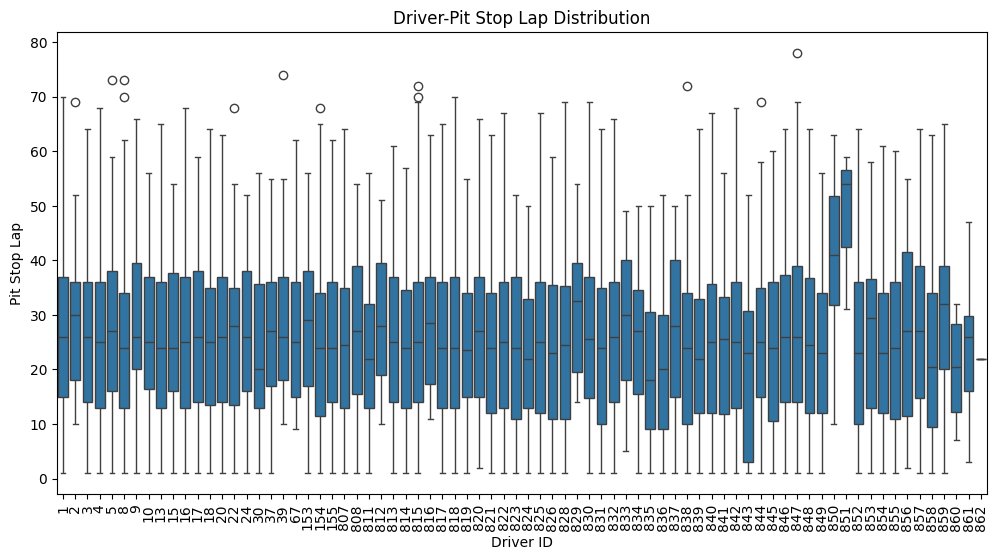

In [25]:
# 드라이버별 피트스톱 패턴 확인 (박스플롯)
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x="driverId", y="lap")
plt.xticks(rotation=90)
plt.title("Driver-Pit Stop Lap Distribution")
plt.xlabel("Driver ID")
plt.ylabel("Pit Stop Lap")
plt.show()

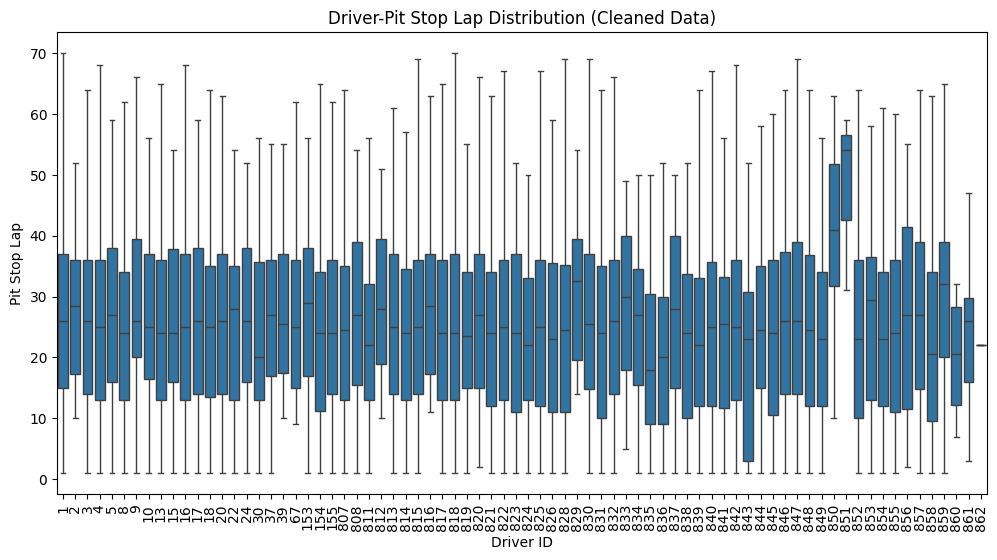

In [26]:
Q1 = df.groupby('driverId')['lap'].quantile(0.25)
Q3 = df.groupby('driverId')['lap'].quantile(0.75)
IQR = Q3 - Q1

# 드라이버별 -> 이상치의 lower bound, upper bound 계산
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 이상치 전처리 (각 드라이버의 lap 값이 범위 밖에 있는 경우)
df_cleaned = df[(df['lap'] >= df['driverId'].map(lower_bound)) & (df['lap'] <= df['driverId'].map(upper_bound))]

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_cleaned, x="driverId", y="lap")
plt.xticks(rotation=90)
plt.title("Driver-Pit Stop Lap Distribution (Cleaned Data)")
plt.xlabel("Driver ID")
plt.ylabel("Pit Stop Lap")
plt.show()


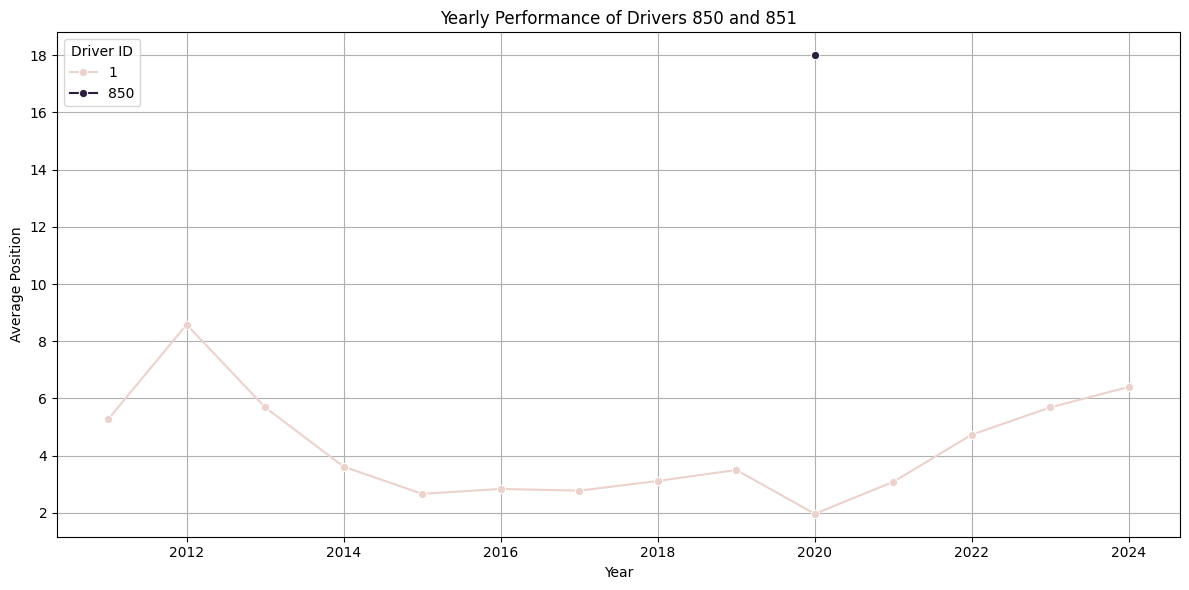

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns

# driverId가 850, 851인 선수들의 데이터를 필터링
drivers_850_851 = df[df['driverId'].isin([850, 1])]

# 각 드라이버의 연도별 성적 (final_position 평균)
driver_performance = drivers_850_851.groupby(['year', 'driverId']).agg(
    avg_position=('positionOrder', 'mean')
).reset_index()

# 시각화
plt.figure(figsize=(12, 6))
sns.lineplot(data=driver_performance, x='year', y='avg_position', hue='driverId', marker='o')

# 제목과 레이블 설정
plt.title('Yearly Performance of Drivers 850 and 851')
plt.xlabel('Year')
plt.ylabel('Average Position')
plt.legend(title='Driver ID', loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


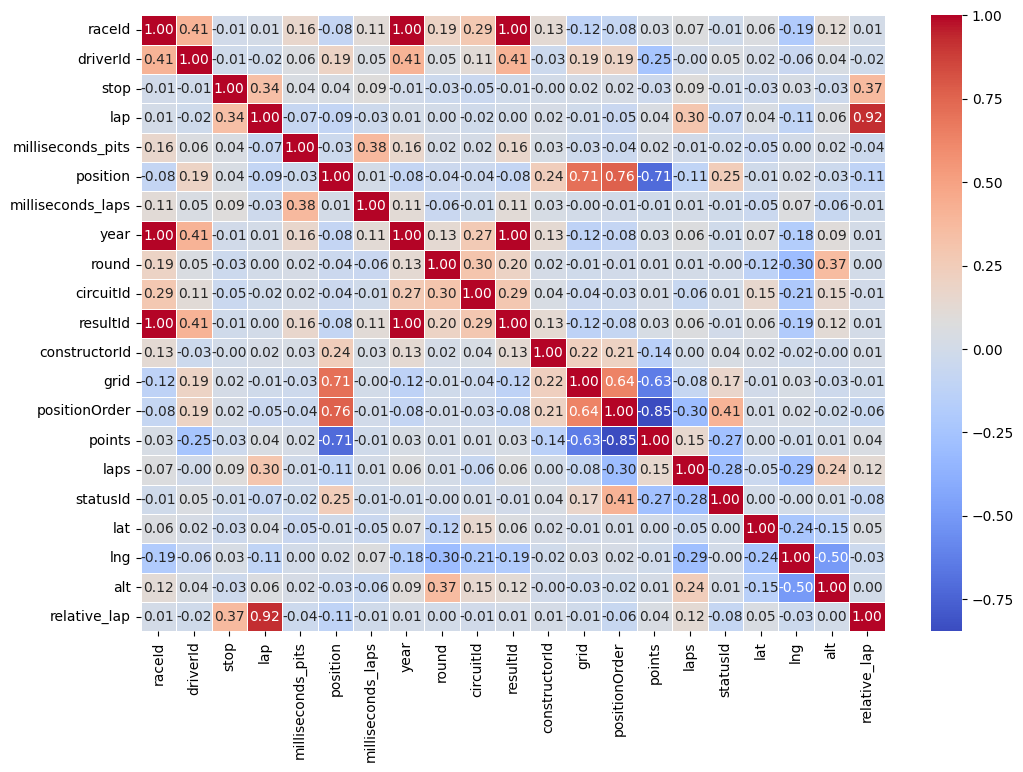

In [27]:
# 변수 간 상관관계 분석 (히트맵)
plt.figure(figsize=(12, 8))
sns.heatmap(df.select_dtypes(include=['int64', 'float64']).corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.show()

**주요 상관관계 분석**

> 출발 위치(grid)와 최종 순위(positionOrder): -0.71
- 출발 위치가 앞쪽일수록 최종 순위가 높아질 가능성이 큼 (**강한 음의 상관관계**)
- 즉, 출발 위치는 경기 결과를 예측하는 중요한 변수


> 출발 위치(grid)와 포인트(points): -0.63
- 위 최종 순위와 마찬가지로 출발 위치가 좋을수록(낮을 수록) 경기에서 더 많은 포인트를 획득할 가능성이 높음


> 최종 순위(positionOrder)와 포인트(points): -0.85
- **순위가 낮을수록(=더 앞 순위일수록) 높은 포인트를 획득**
- 무조건 양의 상관관계만 고려하는 것을 주의해야하는 포인트
- 머신러닝 모델에서 포인트를 타깃 변수로 설정하는 경우 활용 가능


> 랩(lap)과 피트스톱 횟수(stop): 0.34
- 경기에서 진행된 랩 수가 많을수록 피트스톱 횟수가 증가하는 경향
- 하지만 강한 상관관계는 아니므로, 다른 요소와 함께 고려


> 피트스톱 시간(milliseconds_pits)과 순위(position): 0.24
- 피트스톱 시간이 길어질수록 순위가 낮아지는 경향

> 서킷(circuitId)과 피트스톱 랩(lap): 0.30
- 서킷에 따라 피트스톱이 발생하는 랩이 달라지는 경향 존재
- 머신러닝 모델에서 서킷별 전략 차이를 고려할 필요가 있음

### **데이터 전처리**

In [28]:
db = df.copy()
db.head()

,raceId,driverId,stop,lap,time_pits,duration,milliseconds_pits,position,time_laps,milliseconds_laps,...,rank,statusId,circuitRef,circuit_name,circuit_location,circuit_country,lat,lng,alt,relative_lap
0,841,153,1,1,17:05:23,26.898,26898,21,2:13.879,133879,...,10,11,albert_park,Albert Park Grand Prix Circuit,Melbourne,Australia,-37.8497,144.968,10,0.020833
1,841,30,1,1,17:05:52,25.021,25021,22,2:41.428,161428,...,21,4,albert_park,Albert Park Grand Prix Circuit,Melbourne,Australia,-37.8497,144.968,10,0.020833
2,841,17,1,11,17:20:48,23.426,23426,7,1:54.995,114995,...,3,1,albert_park,Albert Park Grand Prix Circuit,Melbourne,Australia,-37.8497,144.968,10,0.229167
3,841,4,1,12,17:22:34,23.251,23251,12,1:52.624,112624,...,2,1,albert_park,Albert Park Grand Prix Circuit,Melbourne,Australia,-37.8497,144.968,10,0.250000
4,841,13,1,13,17:24:10,23.842,23842,11,1:54.060,114060,...,1,1,albert_park,Albert Park Grand Prix Circuit,Melbourne,Australia,-37.8497,144.968,10,0.270833


중복 및 필요없는 컬럼

In [29]:
# position_results 와 positionOrder가 겹침
# 수치형인 positionOrder만 남김
# 서킷(위치, 경도 등) 필요없음
db = db.drop(columns=['position_results'])
db = db.drop(columns=['lng'])
db = db.drop(columns=['lat'])
db = db.drop(columns=['alt'])
print(db.columns)

Index(['raceId', 'driverId', 'stop', 'lap', 'time_pits', 'duration',
       'milliseconds_pits', 'position', 'time_laps', 'milliseconds_laps',
       'year', 'round', 'circuitId', 'race_name', 'date', 'time', 'resultId',
       'constructorId', 'number', 'grid', 'positionOrder', 'points', 'laps',
       'time_results', 'milliseconds', 'fastestLap', 'rank', 'statusId',
       'circuitRef', 'circuit_name', 'circuit_location', 'circuit_country',
       'relative_lap'],
      dtype='object')


In [30]:
# duration -> milliseconds_pit
# 밀리초 단위로 보면 됨, 초단위인 duration은 필요없으니 제거
db = db.drop(columns=['duration'])
print(db.columns)

Index(['raceId', 'driverId', 'stop', 'lap', 'time_pits', 'milliseconds_pits',
       'position', 'time_laps', 'milliseconds_laps', 'year', 'round',
       'circuitId', 'race_name', 'date', 'time', 'resultId', 'constructorId',
       'number', 'grid', 'positionOrder', 'points', 'laps', 'time_results',
       'milliseconds', 'fastestLap', 'rank', 'statusId', 'circuitRef',
       'circuit_name', 'circuit_location', 'circuit_country', 'relative_lap'],
      dtype='object')


데이터 타입 변환 (범주 -> 수치)

In [31]:
# milliseconds_pits(피트 스탑 타임-밀리초)와 final_position은 숫자로 변환되어야 한다!
db['time_pits'] = pd.to_numeric(db['time_pits'], errors='coerce')
db['milliseconds_pits'] = pd.to_numeric(db['milliseconds_pits'], errors='coerce')

# position -> 최종 순위로 구분하기 위해 final_position으로 변수명 변경
db['final_position'] = pd.to_numeric(db['position'], errors='coerce')
db['number'] = pd.to_numeric(db['number'], errors='coerce')
db['fastestLap'] = pd.to_numeric(db['fastestLap'], errors='coerce')

결측값 확인 및 제거

In [32]:
db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11371 entries, 0 to 11370
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   raceId             11371 non-null  int64  
 1   driverId           11371 non-null  int64  
 2   stop               11371 non-null  int64  
 3   lap                11371 non-null  int64  
 4   time_pits          0 non-null      float64
 5   milliseconds_pits  11371 non-null  int64  
 6   position           11371 non-null  int64  
 7   time_laps          11371 non-null  object 
 8   milliseconds_laps  11371 non-null  int64  
 9   year               11371 non-null  int64  
 10  round              11371 non-null  int64  
 11  circuitId          11371 non-null  int64  
 12  race_name          11371 non-null  object 
 13  date               11371 non-null  object 
 14  time               11371 non-null  object 
 15  resultId           11371 non-null  int64  
 16  constructorId      113

In [33]:
from google.colab import files
db.to_csv('f1_2.csv', index=False)

files.download('f1_2.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

+추가 EDA

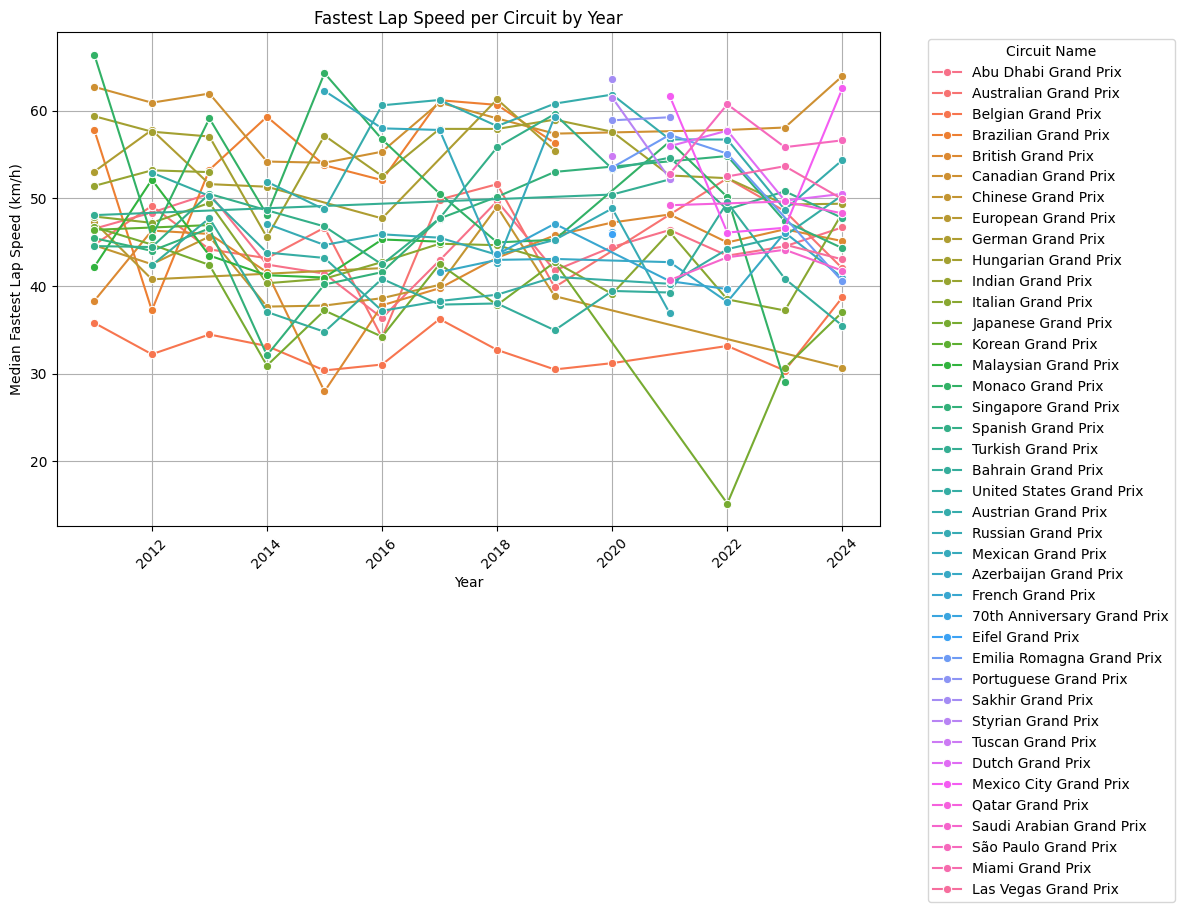

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

# 평균 fastestLapSpeed 계산
df_speed = db.groupby(['year', 'race_name']).agg(
    medianFastestLapSpeed=('fastestLap', 'mean')
).reset_index()

# Fastest Lap Speed per Circuit by Year
plt.figure(figsize=(12, 8))
sns.lineplot(data=df_speed, x='year', y='medianFastestLapSpeed', hue='race_name', marker='o')
plt.title("Fastest Lap Speed per Circuit by Year")
plt.xlabel('Year')
plt.ylabel('Median Fastest Lap Speed (km/h)')
plt.xticks(rotation=45)
plt.legend(title='Circuit Name', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


### 피쳐 엔지니어링(feature engineering)
> 피트스탑 전략 수립을 위해 피트 스톱 관련 변수들을 생성,

- 총 피트스탑 횟수 `total_stops`
- 평균 피트스톱 시간 `avg_stop_duration`
- 가장 이른 피트스톱 랩 `earliest_stop_lap`
- 가장 늦은 피트스톱 랩 `latest_stop_lap`

```
해당 변수들과 기존 변수들 간의 상관관계 체크
```

> 예상 인사이트:

- 총 피트스톱 횟수: 더 많은 피트스톱을 한 드라이버는 일반적으로 레이스에서 성적이 떨어지기 쉽습니다.

- 평균 피트스톱 시간: 피트스톱 시간이 긴 드라이버는 상대적으로 더 낮은 성적을 기록할 가능성이 높습니다.

- 피트스톱 타이밍(이르거나/늦은): 이른 피트스톱을 한 드라이버가 유리할 수 있음을 알 수 있습니다.

In [35]:
pit_summary = db.groupby(['raceId', 'driverId']).agg(
    total_stops=('stop', 'count'),
    avg_stop_duration=('milliseconds_pits', 'mean'),
    earliest_stop_lap=('lap', 'min'),
    latest_stop_lap=('lap', 'max')
).reset_index()

# 피트스탑 요약 데이터 확인
pit_summary.head()

,raceId,driverId,total_stops,avg_stop_duration,earliest_stop_lap,latest_stop_lap
0,841,1,2,23213.0,16,36
1,841,2,2,24046.0,15,30
2,841,3,1,23716.0,16,16
3,841,4,3,24055.0,12,42
4,841,5,1,24865.0,17,17


In [36]:
pit_summary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5575 entries, 0 to 5574
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   raceId             5575 non-null   int64  
 1   driverId           5575 non-null   int64  
 2   total_stops        5575 non-null   int64  
 3   avg_stop_duration  5575 non-null   float64
 4   earliest_stop_lap  5575 non-null   int64  
 5   latest_stop_lap    5575 non-null   int64  
dtypes: float64(1), int64(5)
memory usage: 261.5 KB


In [37]:
pit_data = pd.merge(pit_summary, db[['raceId', 'driverId', 'position']], on=['raceId', 'driverId'], how='inner')
# 최종 포지션을 숫자로 변환
pit_data['final_position'] = pd.to_numeric(pit_data['position'], errors='coerce')
pit_data.head()


,raceId,driverId,total_stops,avg_stop_duration,earliest_stop_lap,latest_stop_lap,position,final_position
0,841,1,2,23213.0,16,36,1,1
1,841,1,2,23213.0,16,36,2,2
2,841,2,2,24046.0,15,30,16,16
3,841,2,2,24046.0,15,30,14,14
4,841,3,1,23716.0,16,16,8,8


### 피트스톱 시간에 따른 성적 분석

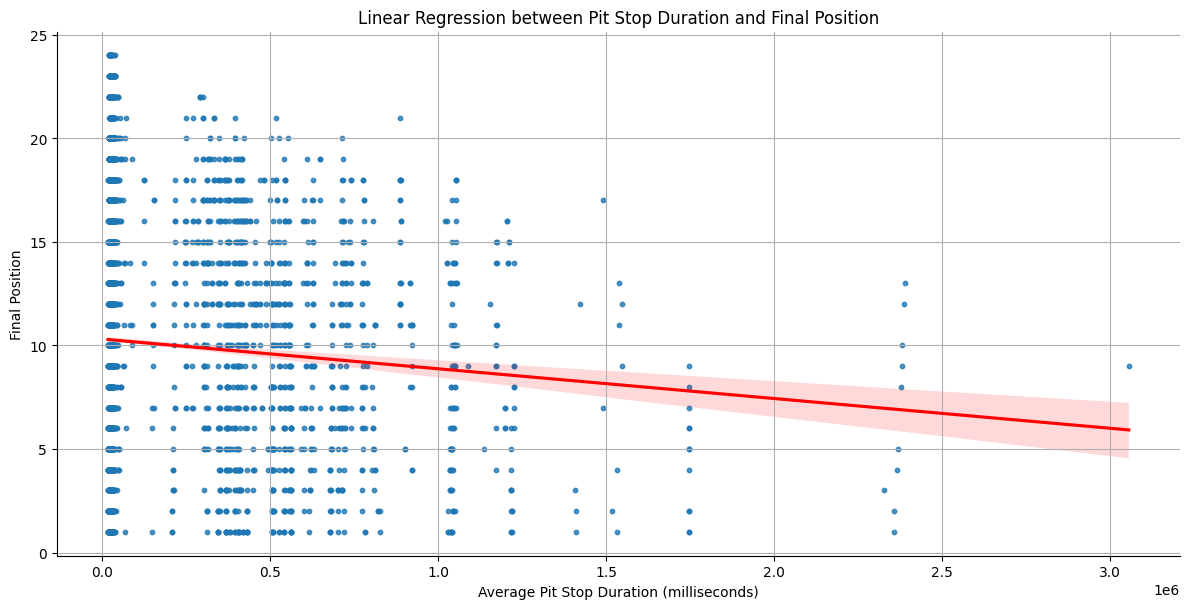

In [74]:
# Linear regression plot: 피트스톱 시간과 최종 순위 간의 관계
sns.lmplot(x='avg_stop_duration', y='final_position', data=pit_data, aspect=2, height=6, scatter_kws={'s': 10}, line_kws={'color': 'red'})
plt.title('Linear Regression between Pit Stop Duration and Final Position')
plt.xlabel('Average Pit Stop Duration (milliseconds)')
plt.ylabel('Final Position')
plt.grid(True)
plt.show()


### 상관 관계 분석

1. 총 피트스톱 횟수와 최종 순위 간의 피어슨 상관관계를 계산하여 두 변수 간의 관계를 파악합니다.

In [38]:
# 피트스톱 횟수와 최종 순위의 평균값 계산
stop_vs_position = pit_data.groupby('total_stops').agg(
    avg_position=('final_position', 'mean')
).reset_index()

print(stop_vs_position.head())

   total_stops  avg_position
0            1      9.268069
1            2      9.838876
2            3     10.624571
3            4     11.035831
4            5     11.410989


A. 피트 스톱 횟수와 최종 순위 간의 피어슨 상관관계는 0.1 수준으로 약하다

In [63]:
import scipy.stats as stats

# 피트스톱 횟수 - 평균 최종 순위 간의 피어슨 상관관계 계산
correlation, p_value = stats.pearsonr(stop_vs_position['total_stops'], stop_vs_position['avg_position'])

print(f"Pearson's correlation coefficient: {correlation}")
print(f"P-value: {p_value}")


Pearson's correlation coefficient: 0.8513638408884768
P-value: 0.015075696139683445


In [65]:
import scipy.stats as stats

# 피트스톱 횟수 - 평균 최종 순위 간의 피어슨 상관관계 계산
correlation, p_value = stats.pearsonr(pit_data['total_stops'], pit_data['final_position'])

print(f"Pearson's correlation coefficient: {correlation}")
print(f"P-value: {p_value}")


Pearson's correlation coefficient: 0.10665376115756975
P-value: 3.9795884809121045e-30


In [40]:
# 피트스톱 횟수와 최종 순위 간의 Pearson 상관계수
cor_stops_position = pit_data[['total_stops', 'final_position']].corr().iloc[0, 1]
print(cor_stops_position)

0.10665376115757022


B. 가장 빠른 피트 스톱 랩과 최종 레이스 위치 사이의 피어슨 상관관계는 -0.1 수준으로 약하다

In [66]:
import scipy.stats as stats

# 피트스톱 횟수 - 평균 최종 순위 간의 피어슨 상관관계 계산
correlation, p_value = stats.pearsonr(pit_data['earliest_stop_lap'], pit_data['final_position'])

print(f"Pearson's correlation coefficient: {correlation}")
print(f"P-value: {p_value}")

Pearson's correlation coefficient: -0.16270207306283974
P-value: 2.679904638759774e-68


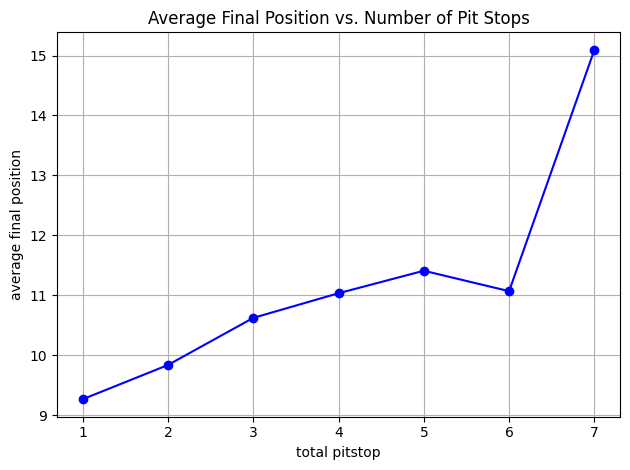

In [42]:
import matplotlib.pyplot as plt

# 피트스탑 횟수와 최종 순위와의 관계 시각화

stop_vs_position = pit_data.groupby('total_stops').agg(
    avg_position=('final_position', 'mean'),
    n=('total_stops', 'count')
).reset_index()

plt.plot(stop_vs_position['total_stops'], stop_vs_position['avg_position'], marker='o', color='blue')
plt.title('Average Final Position vs. Number of Pit Stops')
plt.xlabel('total pitstop')
plt.ylabel('average final position')
plt.grid(True)
plt.tight_layout()
plt.show()


**총 피트스톱 횟수와 최종 순위 간의 피어슨 상관관계**

> 분석 결과, 분석 결과, 피트스톱을 더 많이 하는 드라이버들이 평균적으로 조금 더 낮은 순위를 기록하는 경향은 있다. 하지만 이 관계는 절대적인 것은 아니며, 전략적으로 피트스톱을 활용하면 (타이어를 새로 교체하고 레이스 페이스를 최적화하는 등) 도움이 되어 성과를 개선할 수도 있음에 주목해야 할 것 같다. 오히려 더 이른 피트스톱은 언더컷을 통해 순위를 높이는 데 유리할 수 있으며, 늦은 피트스톱은 효과적으로 트랙 포지션을 활용하는 데 도움이 될 수 있다고 함 (추가 자료조사 결과).

- 상관 계수 (0.11): 약한 양의 상관관계가 있지만 그 관계는 매우 약합니다. 이는 더 많은 피트스톱을 한 드라이버가 성적이 떨어지긴 하지만, 그 효과는 아주 미미하다는 것을 의미합니다.

- p-값 (p-value = 0): 통계적으로 유의미한 결과이므로, 피트스톱 횟수와 성적 간의 관계가 실제로 존재한다고 할 수 있습니다.

In [43]:
# 서킷(경기장)별 피트스탑 전략 분석
circuit_pit_stop_analysis = db.groupby('circuit_name').agg(
    avg_stop_duration=('milliseconds_pits', 'mean'),
    total_stops=('stop', 'sum')
).reset_index()

print(circuit_pit_stop_analysis)


                            circuit_name  avg_stop_duration  total_stops
0         Albert Park Grand Prix Circuit      191301.219048          712
1          Autodromo Enzo e Dino Ferrari      217469.202899          238
2   Autodromo Internazionale del Mugello      529469.500000          199
3           Autodromo Nazionale di Monza       95359.175258          516
4           Autódromo Hermanos Rodríguez      109504.741036          343
5     Autódromo Internacional do Algarve       25186.317647          156
6             Autódromo José Carlos Pace      177625.312411         1462
7          Bahrain International Circuit       57000.428571         1273
8                      Baku City Circuit      216192.726644          515
9            Buddh International Circuit       23944.705882          180
10             Circuit Gilles Villeneuve       24782.892344          669
11                Circuit Park Zandvoort      201343.535088          573
12                   Circuit Paul Ricard       3192

## 주요 분석 결과 & 발견한 인사이트 & 현재까지의 한계점이나 고민 지점

## 주요 분석 결과 & 발견한 인사이트 & 현재까지의 한계점이나 고민 지점

> ### 주요 분석 결과 & 인사이트:
1. **피트스톱 횟수와 최종 순위 간의 관계**:
   - **상관관계**: 피트스톱 횟수와 최종 순위 간에는 약한 양의 상관관계가 있음 (상관계수: 0.11, p-value < 0.05).
   - **해석**: 피트스톱을 더 많이 한 드라이버들이 평균적으로 성적이 더 나쁜 경향이 있지만, 그 관계는 미미함. 따라서, 피트스톱 횟수가 많다고 무조건 성적이 떨어진다고 단정 짓기는 어려움. 전략적인 다중 피트스톱이 유리한 결과를 가져올 수도 있음.
2. **이른 피트스톱 랩과 최종 순위 간의 관계**:
   - **상관관계**: 가장 이른 피트스톱 랩과 최종 순위 간에는 약한 음의 상관관계가 있음 (상관계수: -0.08, p-value < 0.05).
   - **해석**: 이른 피트스톱이 성적에 미치는 영향은 약하지만 긍정적인 경향을 보이며, 언더컷 전략을 통해 더 좋은 순위를 얻을 가능성이 있음.
3. **피트스톱 시간과 최종 순위**:
   - **분석**: 평균 피트스톱 시간이 짧을수록 더 좋은 성적을 기록하는 경향이 있음. 이는 시대 흐름에 따라 점점 단축되어 가는 중임
  


> ### 한계점이나 고민 지점:
**피트스톱 전략에서 보다 다양한 변수의 결합 필요성**:
피트스톱 횟수, 타이밍, 지속시간은 서로 연관이 있지만, 그 효과는 서킷의 특성, 날씨, 타이어 전략 등 다양한 외부 요인에 따라 달라질 수 있음. 이러한 외부 변수들을 통합하여 분석하는 것이 필요할 것 같다.

> 시간을 들여 F1 경기를 챙겨 볼 정도는 아니라, 도메인에 관심 있는 팀원이 있는게 중요함을 다시금 느낀 계기였다. 혼자 하는 개인 프로젝트에서는 잘모르는 도메인에 무턱대고 뛰어들지 말자..